** This file gives a brief overview of the capabilities of the code. **

* If you want to predict the spectrum of a star with particular labels, you'll want the "spectral_model" package.
* If you want to fit an observed spectrum, see the "fitting" package.
* Downloading and processing APOGEE spectra is handled by the "process_spectra" package.
* The "utils" package contains some general-purpose functions used by the other packages.
* If you want to get under the hood and train your own models, there some functions in the train_NNs/ directory to get you started.

The model interpolator requires you to pass it the trained neural network (really, a list of biases and weights parameterizing the network), so we read in the network we'll be using at the beginning and then pass it to various functions as we go. This is a bit cumbersome, but the advantage is that if you train a new network (with architechture compatible with the existing code) you can just pass it to the relevant functions without having to rewrite everything.

In [1]:
from __future__ import absolute_import, division, print_function # Python2 compatibility
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from The_Payne import utils
from The_Payne import spectral_model
from The_Payne import fitting

# the following will be used throughout all routines
# these are the default for fitting APOGEE spectra 
# substitutes them if you train different neural networks for other purposes
# the instruction for training a new Payne is included at the end of this tutorial

# read in the default wavelength array, 
#         the apogee mask/filter used for fitting spectra : True = excluded
wavelength = utils.load_wavelength_array()
mask = utils.load_apogee_mask()
#mask = np.zeros(wavelength.size) # no masking

# read in the neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network()
w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs


Let's use the data-driven spectral model to predict the APOGEE-like spectrum of a single star similar to the Sun.

(26,)


(0.7, 1.05)

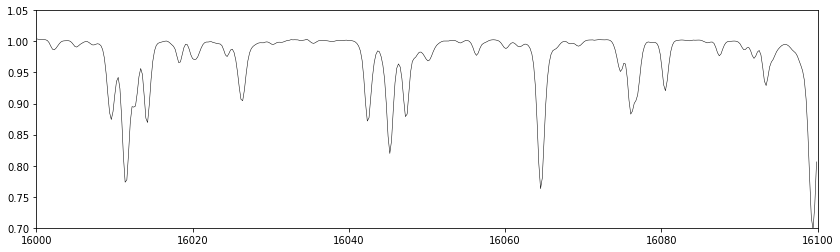

In [2]:
spec_err = 1e-2*np.ones(len(wavelength))

# for a single-star model, the format of "labels" is [Teff, Logg, Vturb [km/s],
#              [C/H], [N/H], [O/H], [Na/H], [Mg/H],\
#              [Al/H], [Si/H], [P/H], [S/H], [K/H],\
#              [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],\
#              [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],\
#              C12/C13, Vmacro [km/s], radial velocity (RV)
real_labels = scaled_labels = [5770, 4.44, 1.0,\
                               0., 0., 0., 0., 0.,\
                               0., 0., 0., 0., 0.,\
                               0., 0., 0., 0., 0.,\
                               0., 0., 0., 0., 0.,\
                               90., 6., 3.] # assuming RV = 3 km/s. 

# scale the labels (except for RV) the same as it was done during the training of the network
scaled_labels[:-1] = (real_labels[:-1]-x_min)/(x_max-x_min) - 0.5
print(np.array(scaled_labels).shape)

real_spec = spectral_model.get_spectrum_from_neural_net(scaled_labels = scaled_labels[:-1], NN_coeffs = NN_coeffs)
real_spec = utils.doppler_shift(wavelength, real_spec, scaled_labels[-1])

# zoom in on a small region of the spectrum so we can see what's going on.
lambda_min, lambda_max = 16000, 16100# for plotting 
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], real_spec[m], 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.05)

Now let's add some noise to this model spectrum, and then fit it to see if we can recover the labels we put in. 

In [3]:
data_spec = real_spec + 0.01*np.random.randn(len(real_spec))

tol = 5e-4 # tolerance for when the optimizer should stop optimizing.

# assuming your NN has two hidden layers. 
w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs
    
def fit_func(dummy_variable, *labels):
    norm_spec = spectral_model.get_spectrum_from_neural_net(scaled_labels = labels[:-1], 
            NN_coeffs = NN_coeffs)
    norm_spec = utils.doppler_shift(wavelength, norm_spec, labels[-1])
    return norm_spec
    
# if no initial guess is supplied
# here we operate in the scaled label space
p0 = np.zeros(26)
        
# don't allow the minimimizer to go outside the range of training set
bounds = np.zeros((2,26))
bounds[0,:] = -0.5
bounds[1,:] = 0.5
bounds[0,-1] = -5.
bounds[1,-1] = 5.

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit_func, xdata=[], ydata = data_spec, sigma = spec_err, p0 = p0,
                bounds = bounds, ftol = tol, xtol = tol, absolute_sigma = True, method = 'trf')


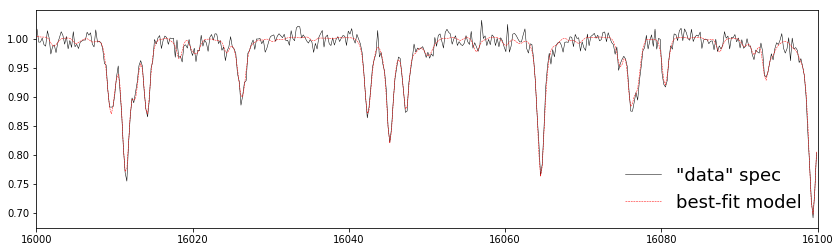

In [4]:
data_spec = real_spec + 0.01*np.random.randn(len(real_spec))

popt, pcov, model_spec = fitting.fit_normalized_spectrum_single_star_model(\
                                norm_spec = data_spec, spec_err = spec_err,\
                                NN_coeffs = NN_coeffs, wavelength = wavelength, mask=mask, p0 = None)

plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"data" spec')
plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'best-fit model')
plt.xlim(lambda_min, lambda_max)
plt.legend(loc = 'best', frameon = False, fontsize = 18)

In [5]:
# verify that our best-fit labels are close to what we put in. 
print(popt)

[ 5.82431291e+03  4.49507234e+00  9.58095981e-01  3.02020404e-02
  1.50435495e-02 -2.99434569e-02 -7.17356782e-02  1.00145049e-02
  3.45898217e-02  2.24954774e-02  2.37663058e-01  1.50134926e-02
  5.70408162e-02  1.72346756e-02  3.24316125e-02 -2.83710258e-02
 -1.29372865e-01  4.42806028e-02  2.45146268e-02  1.64811733e-01
  3.36542433e-02  1.53079524e-01 -9.51493915e-02  5.56021166e+01
  5.42434892e+00  2.98843179e+00]


Now that we've seen how to generate and fit model spectra, let's download an actual APOGEE spectrum. Here we'll download a "combined" spectrum. 

Note: Downloading the spectra requires you to have Jo Bovy's Apogee package installed.

Note: Here we adopt APOGEE DR14. Edit os.environs in the "process_spectra" source codes for a later version of APOGEE data release. Since our neural network training set was normalized using the DR12 wavelength definition, even thought the spectra are from DR14, we will resample them into the DR12 wavelength format.

In [ ]:
from The_Payne import process_spectra

apogee_id = '2M18513961+4338099' # make sure the apogee id is in the right string format
spec, spec_err = process_spectra.get_combined_spectrum_single_object(apogee_id = apogee_id, 
                    catalog = None, save_local = False)

plt.figure(figsize=(14, 4))
m = (spec_err < 0.1) & (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], spec[m], 'k', lw=0.5)
plt.ylim(0.75, 1.05)
plt.xlim(lambda_min, lambda_max)

Now let's fit this spectrum with The-Payne-interpolated model.

In [ ]:
popt, pcov, best_fit_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = spec, 
        spec_err = spec_err, NN_coeffs = NN_coeffs, wavelength=wavelength, mask=mask, p0 = None)

plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], spec[m], 'k', lw=0.5, label = 'APOGEE spectrum')
plt.plot(wavelength[m], best_fit_spec[m], 'r', lw=0.5, label = 'Best-fit model')
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.1)
plt.legend(loc = 'best', frameon = False, fontsize= 18)

Training new neural networks.

In [ ]:
training_labels, training_spectra, validation_labels, validation_spectra = utils.load_training_data()

**One practical note:**

Fitting combined spectra with The Payne is pretty fast. If you pass the fitting function to a Python multiprocessing Pool, you should be able to comfortably fit 10,000 targets in < 1 day on a single node of a typical cluster. 
